In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from fsam.fsam_fit import FSAM

In [2]:
def get_y_linear(X):
    return np.block(
        [
            [np.multiply(2, X[:, 0])],
            [np.zeros((X.shape[0],))],
            [np.multiply(1, X[:, 2])],
            [np.zeros((X.shape[0],))],
        ]
    ).T


def get_y_nonlinear(X):
    return np.block(
        [
            [np.zeros((X.shape[0],))],
            [np.sin(X[:, 1] * 4)],
            [np.zeros((X.shape[0],))],
            [-2 * np.square(X[:, 3]) + 1],
        ]
    ).T

In [3]:
m, n = 4, 200
train_size = 0.5
np.random.seed(0)
X = np.random.uniform(-1, 1, (n, m))
y_linear = get_y_linear(X)
y_nonlinear = get_y_nonlinear(X)
y_min, y_max = (
    np.concatenate((y_linear, y_nonlinear), axis=1).min(),
    np.concatenate((y_linear, y_nonlinear), axis=1).max(),
)

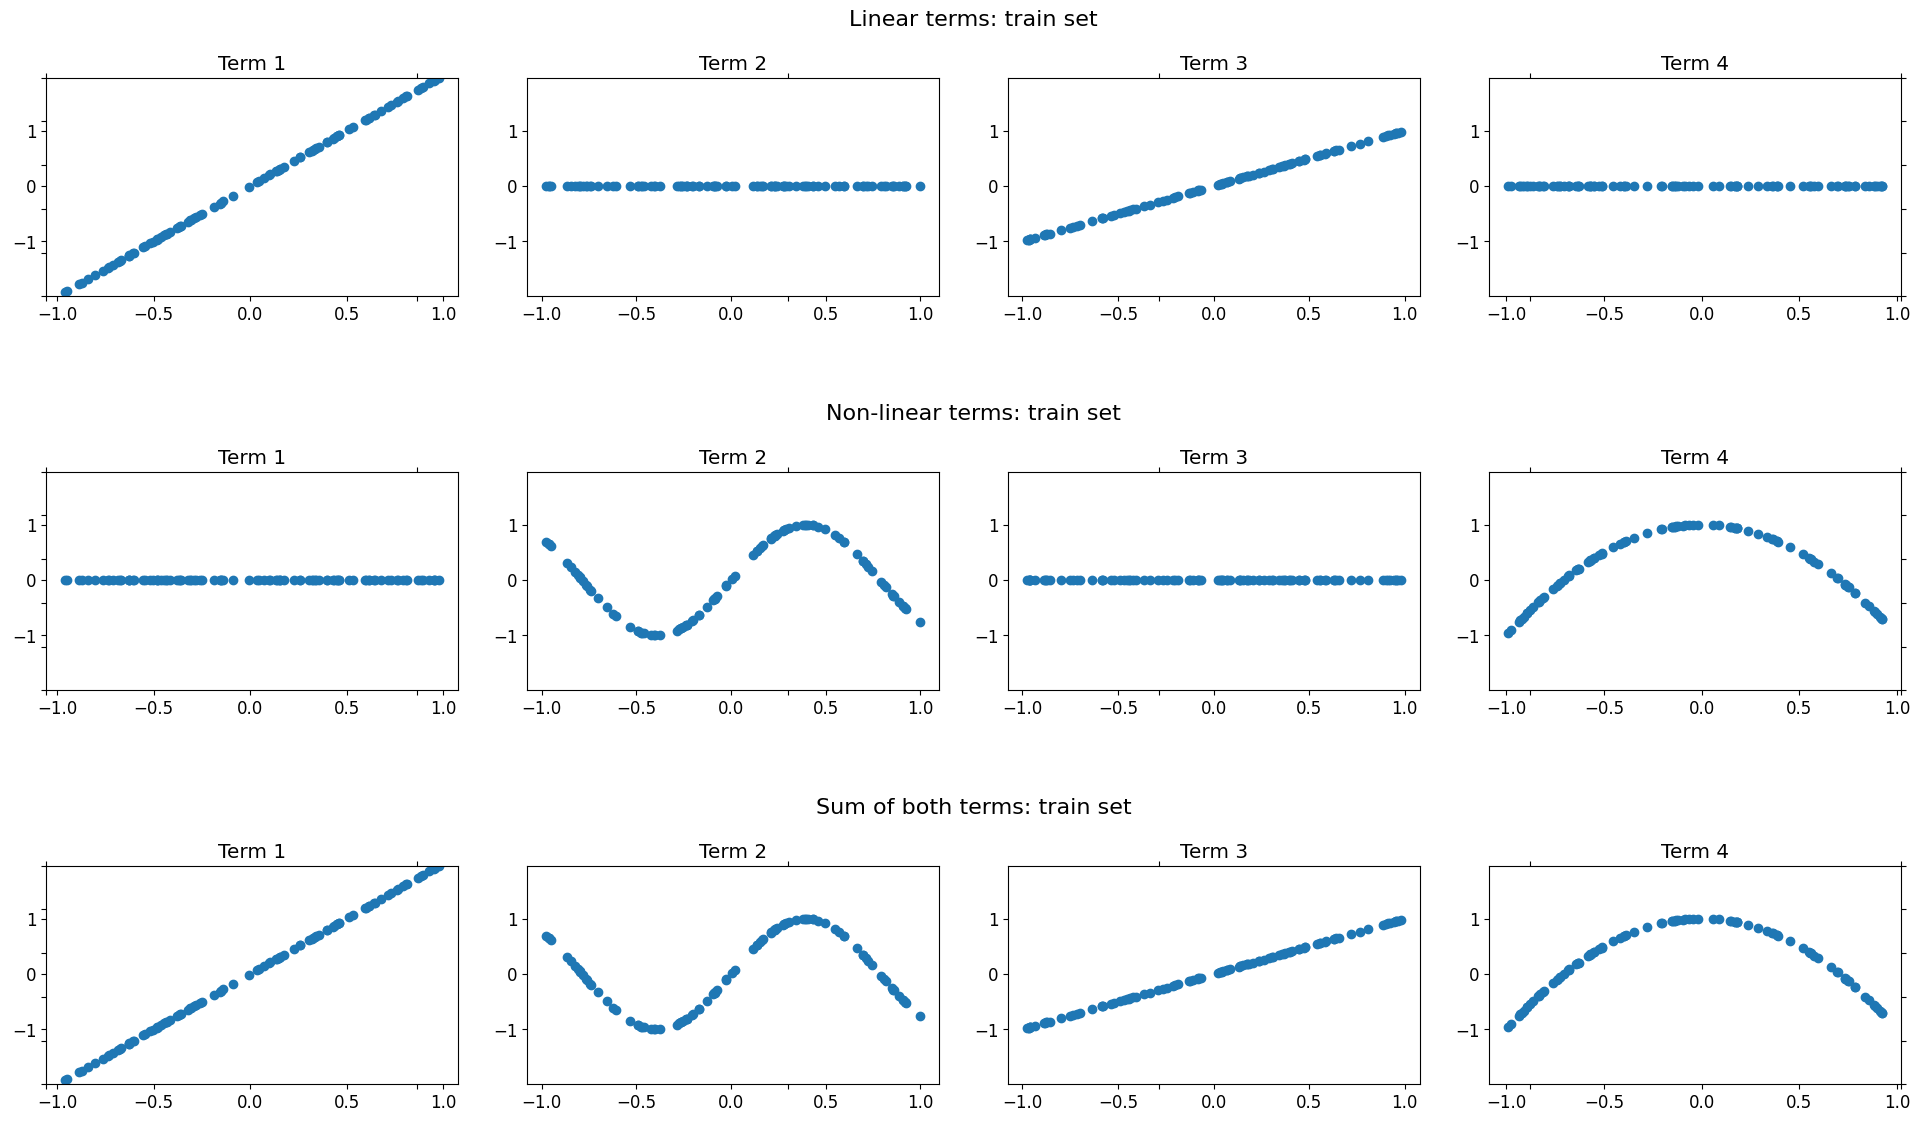

In [4]:
plt.rcParams.update({"font.size": 12})
fig, axes = plt.subplots(3, 1, figsize=(20, 12))
for title, row_ax in zip(
    [
        "Linear terms: train set",
        "Non-linear terms: train set",
        "Sum of both terms: train set",
    ],
    axes,
):
    _ = row_ax.set_title(title, fontsize=16, x=0.5, y=1.2)
    _ = row_ax.tick_params(
        labelcolor=(1.0, 1.0, 1.0, 0.0),
        top="off",
        bottom="off",
        left="off",
        right="off",
    )
    _ = row_ax._frameon = False
for i in range(1, 13):
    ax = fig.add_subplot(3, 4, i)
    _ = ax.set_title(f"Term {((i-1) % 4) + 1}")
    _ = ax.set_ylim(y_min, y_max)
    if ((i - 1) / 12) < 1 / 3:
        _ = ax.scatter(
            X[: int(n * train_size), (i - 1) % 4],
            y_linear[: int(n * train_size), (i - 1) % 4],
        )
    elif 1 / 3 <= ((i - 1) / 12) < 2 / 3:
        _ = ax.scatter(
            X[: int(n * train_size), (i - 1) % 4],
            y_nonlinear[: int(n * train_size), (i - 1) % 4],
        )
    elif 2 / 3 <= ((i - 1) / 12) <= 1:
        _ = ax.scatter(
            X[: int(n * train_size), (i - 1) % 4],
            y_nonlinear[: int(n * train_size), (i - 1) % 4]
            + y_linear[: int(n * train_size), (i - 1) % 4],
        )

fig.set_facecolor("w")
fig.tight_layout()

In [5]:
var_sec = FSAM(deg=[3] * m, ord_d=[2] * m, n_int=[30] * m)
_ = var_sec.fit(
    X=X,
    y=y_linear.sum(axis=1) + y_nonlinear.sum(axis=1),
    K=list(range(1, 9)),
    warm_start=False,
    train_size=train_size,
    conf_model={"q": 8, "max_iter": 1},
    conf_gurobi={"OutputFlag": 0, "threads": 1},
)


K: [1, 2, 3, 4, 5, 6, 7, 8] :   0%|          | 0/8 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-14


In [6]:
k = 4
opt_coefs = var_sec.reg_coefficients[k]

coefs = pd.DataFrame(
    pd.cut(
        pd.Series(opt_coefs[1:]).reset_index(drop=True).index,
        var_sec.range_vars,
        right=False,
    )
).assign(coefs=opt_coefs[1:])
coefs = (
    coefs.reset_index(drop=False)
    .pivot(index="index", columns=0, values="coefs")
    .fillna(0)
    .T.reset_index(drop=True)
    .T
)
coefs = pd.concat((pd.DataFrame(np.repeat(0, 8)).T, coefs), axis=0).reset_index(
    drop=True
)

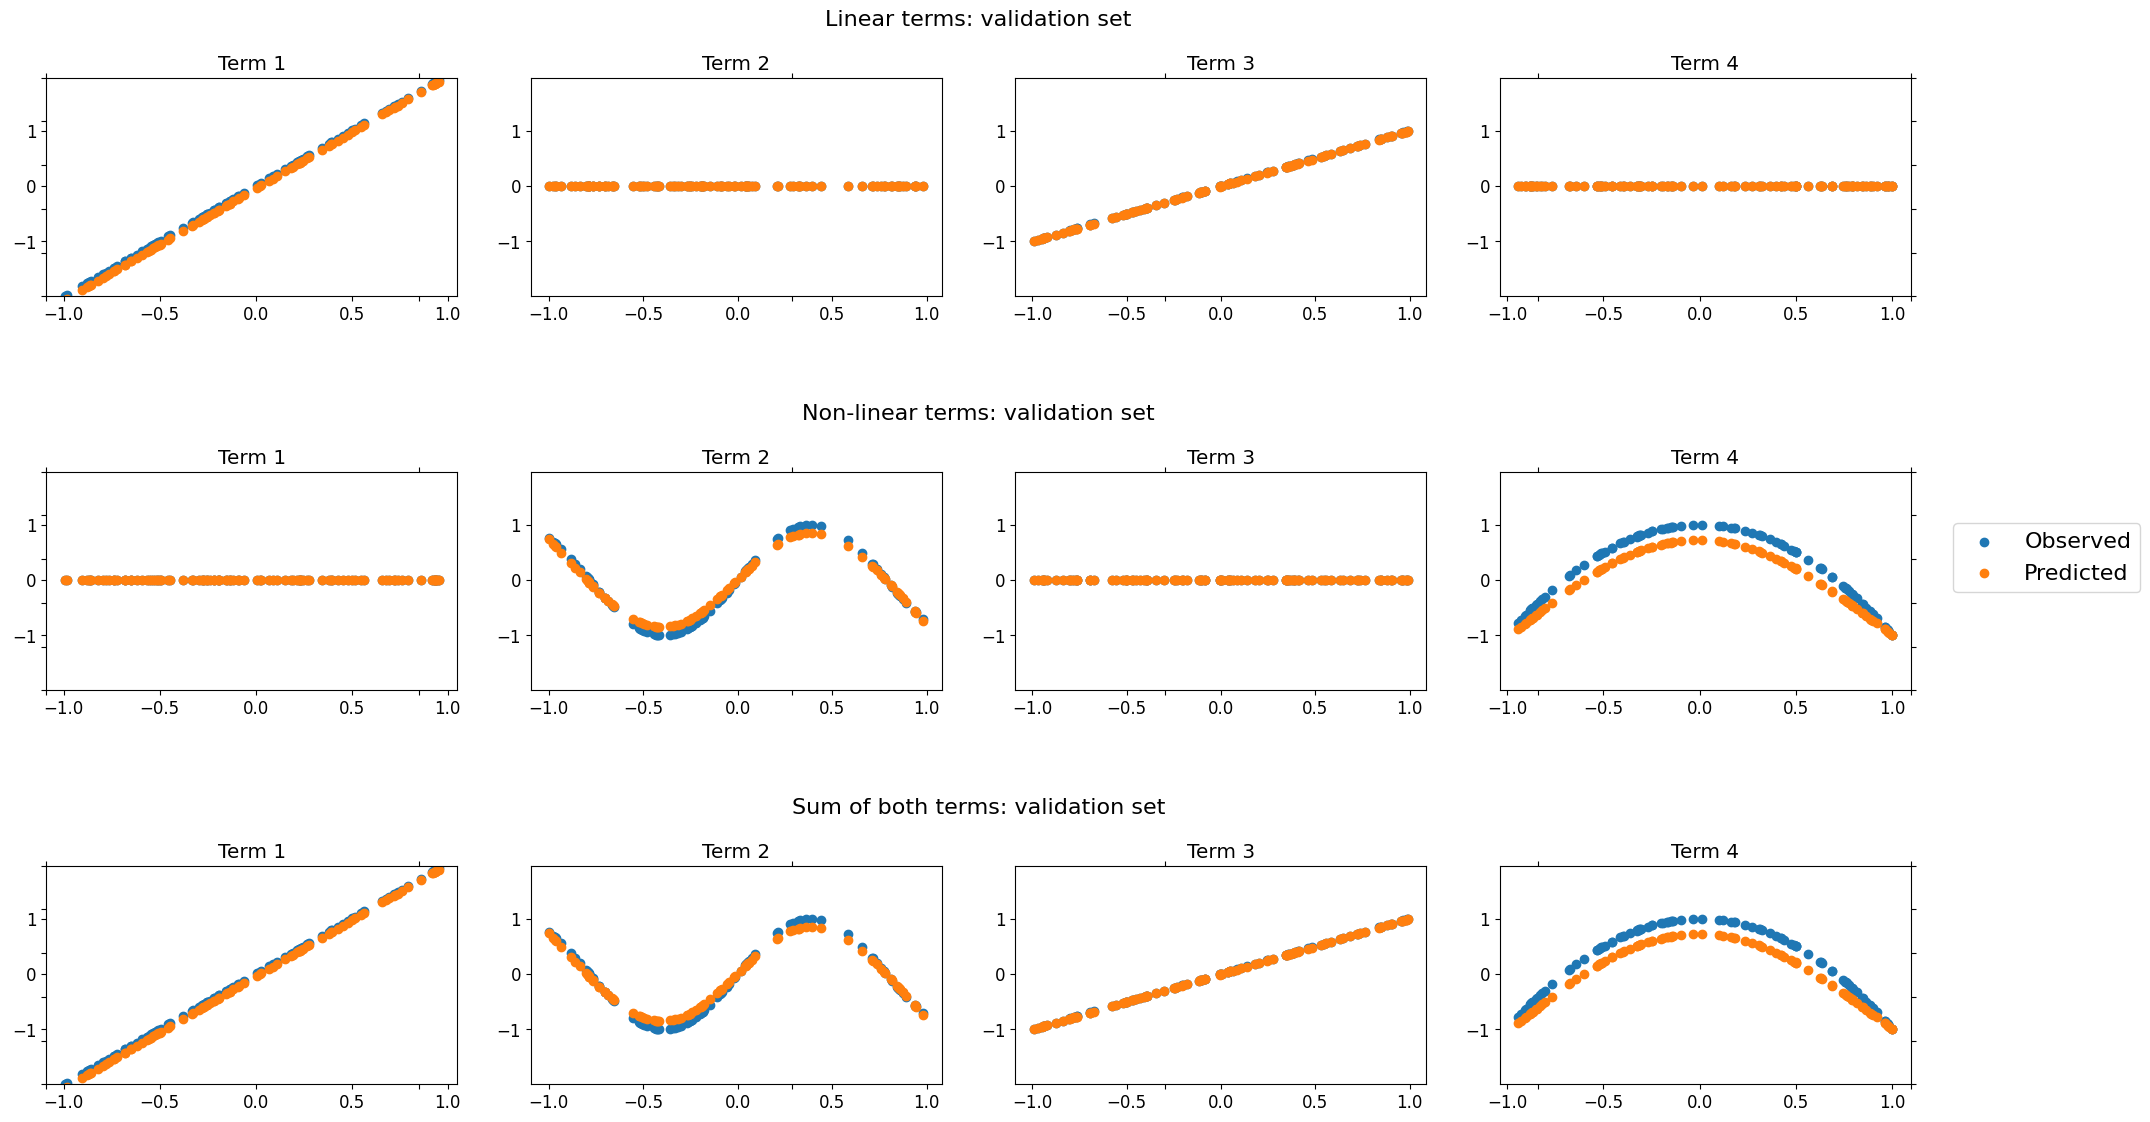

In [7]:
plt.rcParams.update({"font.size": 12})
fig, axes = plt.subplots(3, 1, figsize=(20, 12))
for title, row_ax in zip(
    [
        "Linear terms: validation set",
        "Non-linear terms: validation set",
        "Sum of both terms: validation set",
    ],
    axes,
):
    _ = row_ax.set_title(title, fontsize=16, x=0.5, y=1.2)
    _ = row_ax.tick_params(
        labelcolor=(1.0, 1.0, 1.0, 0.0),
        top="off",
        bottom="off",
        left="off",
        right="off",
    )
    _ = row_ax._frameon = False
for i in range(1, 13):
    ax = fig.add_subplot(3, 4, i)
    _ = ax.set_title(f"Term {((i-1) % 4) + 1}")
    _ = ax.set_ylim(y_min, y_max)
    if ((i - 1) / 12) < 1 / 3:
        _ = ax.scatter(
            X[int(n * train_size) :, (i - 1) % 4],
            y_linear[int(n * train_size) :, (i - 1) % 4],
        )
        _ = ax.scatter(
            X[int(n * train_size) :, (i - 1) % 4],
            var_sec.predict(X[int(n * train_size) :, :], coefs.loc[:, (i - 1) % 4]),
        )
    elif 1 / 3 <= ((i - 1) / 12) < 2 / 3:
        _ = ax.scatter(
            X[int(n * train_size) :, (i - 1) % 4],
            y_nonlinear[int(n * train_size) :, (i - 1) % 4],
        )
        _ = ax.scatter(
            X[int(n * train_size) :, (i - 1) % 4],
            var_sec.predict(
                X[int(n * train_size) :, :], coefs.loc[:, 4 + ((i - 1) % 4)]
            ),
        )
    elif 2 / 3 <= ((i - 1) / 12) < 1:
        _ = ax.scatter(
            X[int(n * train_size) :, (i - 1) % 4],
            y_nonlinear[int(n * train_size) :, (i - 1) % 4]
            + y_linear[int(n * train_size) :, (i - 1) % 4],
        )
        _ = ax.scatter(
            X[int(n * train_size) :, (i - 1) % 4],
            var_sec.predict(X[int(n * train_size) :, :], coefs.loc[:, (i - 1) % 4])
            + var_sec.predict(
                X[int(n * train_size) :, :], coefs.loc[:, 4 + ((i - 1) % 4)]
            ),
        )

_ = fig.set_facecolor("w")
_ = fig.tight_layout()
_ = fig.legend(
    labels=["Observed", "Predicted"],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    prop={"size": 16},
)